# Autothresholding in Julia

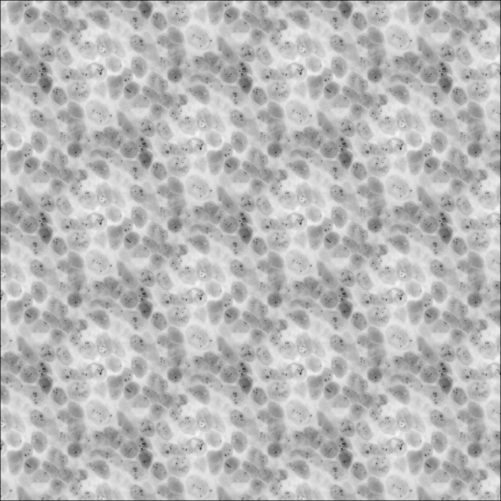

In [79]:
using Images
using IJulia
using Plots
using Interpolations
function resize(img)
    imresize(img, (300, 300), method=Interpolations.Constant())
end

Image = Matrix{Gray{Float32}}

img = load("./images/input/cells4000.jpg")
img = Gray{Float32}.(img)

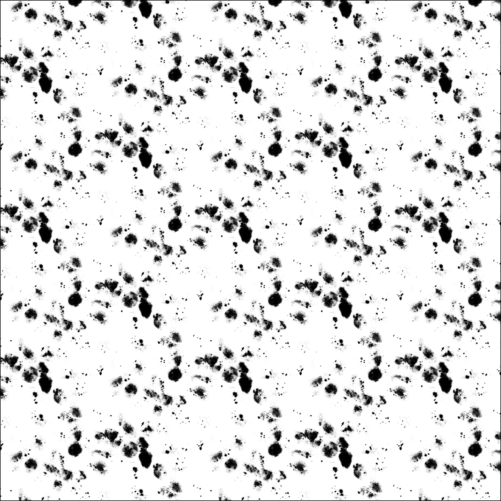

In [128]:
function thresholding(img::Image, thresh)::Image
    (h,w) = size(img)
    output = Gray.(zeros(Float32,h,w))
    for i in 1:h 
        for j in 1:w
            output[i,j] = img[i,j] > thresh ? 1.0 : 0
        end
    end
    output
end

thresholding(img, 0.6)

Min-Max-Threshold: 121


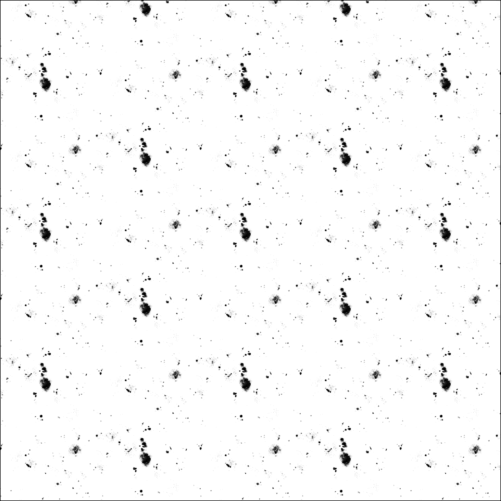

In [144]:
function min_max_thresholding(img::Image)::Image
    min = Inf
    max = -Inf
    (h,w) = size(img)
    for i in 1:h 
        for j in 1:w
            pix = img[i,j]
            if pix > max
                max = pix
            end
            if pix < min
                min = pix
            end
        end
    end
    thresh = (max-min) / 2
    println("Min-Max-Threshold: $(Int(floor(thresh*256)))")
    thresholding(img, thresh)
end
min_max_thresholding(img)

In [133]:
using Plots
function hist(img::Image)::Array{Float32}
    buckets = zeros(Int, 256)
    (h,w) = size(img)
    for i in 1:h 
        for j in 1:w
            index = Int(ceil(img[i,j] * 256 + eps(Float32) ))
            buckets[index]+=1
        end
    end
    return map(buckets) do x
        x/(h*w)
    end
end
hist(img)

# function plothist(hist::Array{Float32})
#     plot(1:length(hist), hist)
# end

# plothist(hist(img))

256-element Vector{Float32}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0003128125
 0.0002841875
 0.0001790625
 0.000170625
 0.00011625
 6.61875f-5
 2.11875f-5
 2.8125f-6
 0.0

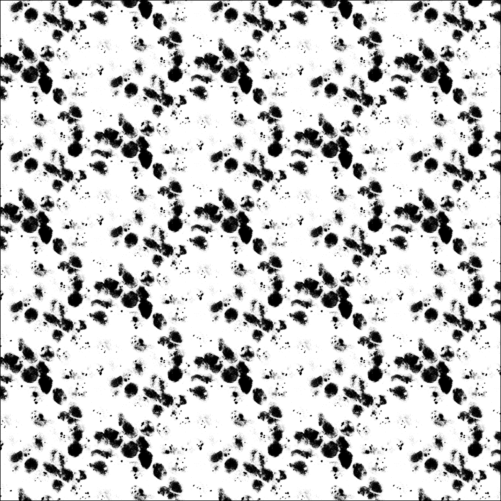

Quantile-0.2 Threshold: 164


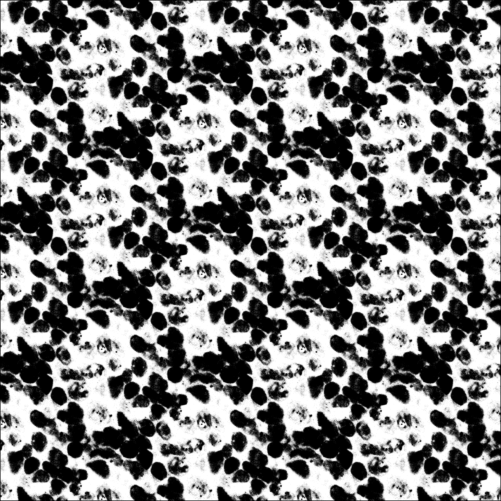

Quantile-0.5 Threshold: 189

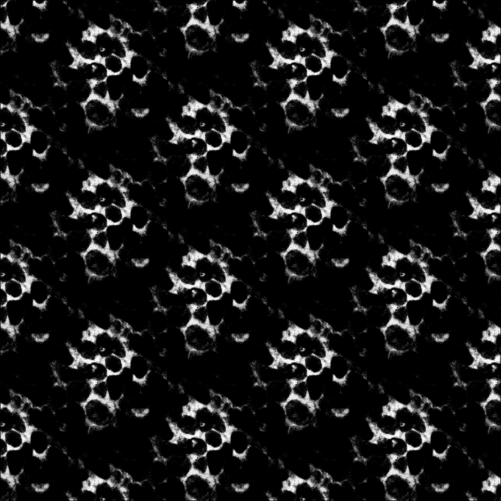


Quantile-0.9 Threshold: 220

In [145]:
function quantile_thresholding(img::Image, quantile=0.5)::Image
    h = hist(img)
    acc = 0.0
    i = 0
    for _ in 1:length(h)
        i+=1
        acc += h[i]
        if acc >= quantile
            break
        end
    end
    println("Quantile-$(quantile) Threshold: $(i)")
    thresholding(img, Float32(i) / 256.0)
end

IJulia.display(quantile_thresholding(img, 0.2))
IJulia.display(quantile_thresholding(img, 0.5))
IJulia.display(quantile_thresholding(img, 0.9))


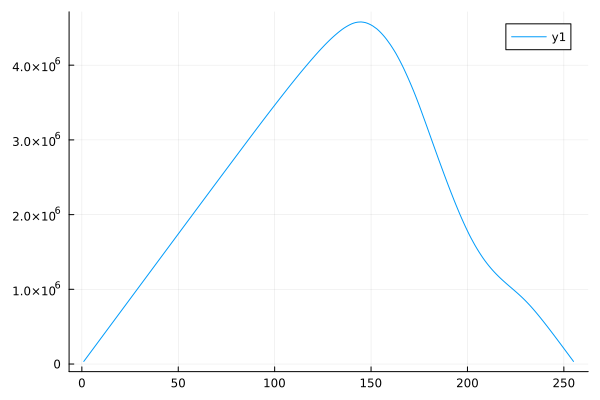

In [139]:
function histmean(h::Array{Float32}; start_val=1)::Float32
    sum(collect(start_val:length(h)+start_val-1) .* h)
end

function otsu_between_variances(hist::Array{Float32})::Array{Float32}
    mean =  histmean(hist)    
    between_variances = zeros(length(hist)-1)
    for i in 1:(length(hist)-1)
        # all pixels <= i belong to one category, > i to the other
        # calculate between class variance:
        sec1 = range(1,i)
        sec2 = range(i+1,length(hist))
        sec1_mean = histmean(hist[sec1])
        sec2_mean = histmean(hist[sec2], start_val=i+1)
        between_variances[i] = (sec1_mean-mean)^2 * length(sec1) + (sec2_mean -mean)^2 * length(sec2)
    end
    between_variances
end

plot(otsu_between_variances(hist(img)))

Otsu using value 145/255 as threshold

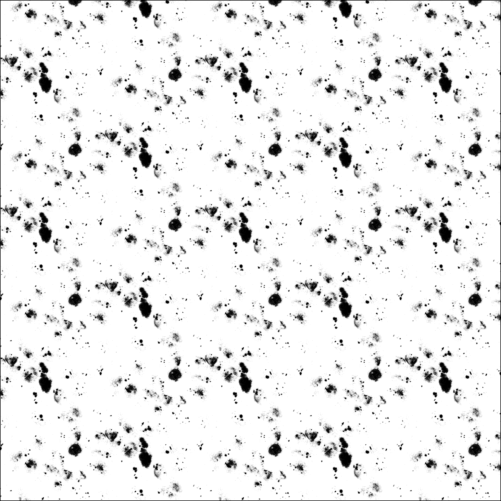

In [140]:
function otsu_thresholding(img::Image)::Image
    _, index = findmax(otsu_between_variances(hist(img)))
    print("Otsu using value $(index)/255 as threshold")
    thresholding(img, Float32(index) / 256.0)
end
otsu_thresholding(img)

q = 186
q = 93
Isodata threshold: 93

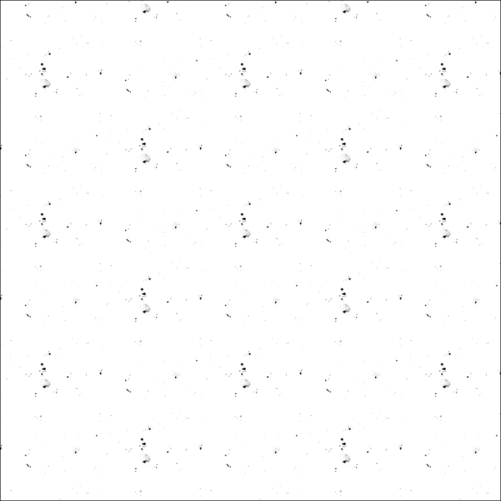

In [141]:
function isodata_threshold(img::Image)::Image
    h = hist(img)
    k = length(h)
    q = floor(Int, histmean(h))
    while true
        @show q
        sec1 = h[1:q]
        sec2 = h[q+1:end]
        if sum(sec1)==0 || sum(sec2) ==0
            throw("No threshold found")
        end
        mu0 = histmean(sec1)
        mu1 = histmean(sec2, start_val=q+1)
        q_old = q
        q = floor(Int, (mu0 + mu1) / 2)
        if q_old == q
            break
        end
    end
    println("Isodata threshold: $(q)")
    thresholding(img, Float32(q) / 256.0)
end
isodata_threshold(img)